In [ ]:
import json
import numpy as np
import torch
import torchvision
import shap
# sypie warningami o braku sterowników do tensor flow

zbiór danych załączony do biblioteki shap. 50 obrazów z google image.

In [2]:
X, y = shap.datasets.imagenet50()
# y nie jest wykorzystywany

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))


Number of ImageNet classes: 1000


Funkcja rotująca kształt tensora, w zależności od tego czy mamy kolekcję obrazów (4 wymiary, n,color,height,width) czy trzy (color,height,width). Funkcja pozostawia n bez zmian (jeśli jest) i przekształca klasyczny obraz (kanał, wiersz, kolumna)  poprzez przeniesienie c na koniec, tak jak w definicji tensora
```
  n number
| c color
| h height rows
V w width cols

n
h
w
c
```

In [3]:
#funkcja sprawdza czy mamy 4 wymiary (wiele obrazów) czy trzy wimiary (jeden obraz)

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

Natępnie ręcznie obrazy są skalowane do przedziału (0,1) a następnie standaryzowane, względem wartości średnich dla kanałów dla pretrenowanej sieci. Proces ten jest połączony w potok (pipe) metodą `Compose`

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Rotacja jest potrzebna aby zastosować transformację obrazu w sposób zwektoryzowany
transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

# transformacja odwrotna służy do wykonania destandaryzacji
inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

#połączenie w pipe
transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

Transformacja do tensora

In [6]:
Xtr = transform(torch.Tensor(X))

Dodajemy urządzenie na którym będziemy wykonywać predykcję. Włączamy cpu jeżeli nie są dostępne odpowiendie sterowniki

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# trochę warningów

## Pierwszy explainer

Użyjemy architektury `mobilenet_v2` z pretrenowanymi wagami `IMAGENET1K_V1`. Dla zadania nie trenujemy sieci. Drugim modelem będzie `vgg16` również z wagami `IMAGENET1K_V1`. Jest to ten sam zbiór do którego nawiązują dane testowe. 

In [7]:
model_mnet = torchvision.models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1', progress=False).to(device).eval()
model_vgg = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').to(device).eval() # inny model

Do zbudowania explainera musimy przygotowany tensor zrotować do postaci `nchw`

Funkcja `predict`, zwraca zawiera obraz (np.array) na tensor, zgodny z urządzeniem (device na którym wykonywana jest predykcja)

In [9]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

predict w celu określenia klasy wynikowej

In [10]:
Xtr = transform(torch.Tensor(X))
out = predict(Xtr[7:8])
classes = torch.argmax(out, axis=1).cpu().numpy() # używam cpu bo mi CUDA nie działa na Waylandzie
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [643]: ['mask']


Budowanie właściwego explainera oraz maskera. Używamy obrazu rozmytego kernelem 64,64 na obrazie o ksztłcie kolekcji obrazów (obliczenia trochę trwają)

In [17]:
masker_blur = shap.maskers.Image("blur(64,64)", Xtr[0].shape)
# funkcja predict, masker output, lista nazw klas
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

Samo wyjaśnianie wymaga wskazania obrazu lub obrazów, zawsze w formie listy, liczby ewaluacji oraz wielkości analizowanego zbioru, tu wszystkie elementy

In [23]:
shap_values = explainer(
    Xtr[7:8],
    max_evals=500, #trochę mało
    batch_size=50, # liczba obiektów
    outputs=shap.Explanation.argsort.flip[:3] # ile przykładów najbardziej podobnych
)

Ponowne przetworzenie danych do formatu obrazu, zamiast `permute` w nparray stosujemy `moveaxis` lub `swapaxis`

In [24]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # cpu ręcznie
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

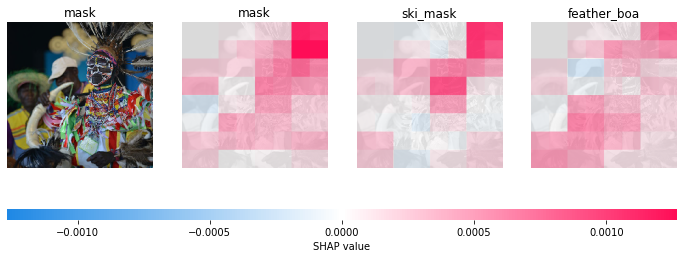

In [25]:
shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[643]],
)

#Wyjaśnianie warstw pośrednich

In [ ]:
e = shap.GradientExplainer((model, model.features[7]), Xtr[7:8])